In [1]:
import torch
from functorch import vmap, grad
from torch.fx import symbolic_trace
from functorch.compile import aot_function, ts_compile, make_boxed_func
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

In [2]:
def lennard_jones(r: torch.Tensor, epsilon: float = 1.0, sigma: float = 1.0):
    """ """
    sigma = torch.tensor(sigma, device=r.device)
    epsilon = torch.tensor(epsilon, device=r.device)
    u = (sigma / r) ** 2
    v = u * u * u
    return torch.tensor(4.0, device=r.device) * epsilon * (v * v - v)


def dlj_dr(r: torch.Tensor, epsilon: float = 1.0, sigma: float = 1.0):
    """"""
    u = -4.0 * epsilon * sigma / r**2
    v = sigma / r
    return u * (12 * v**11 - 6 * v**5)

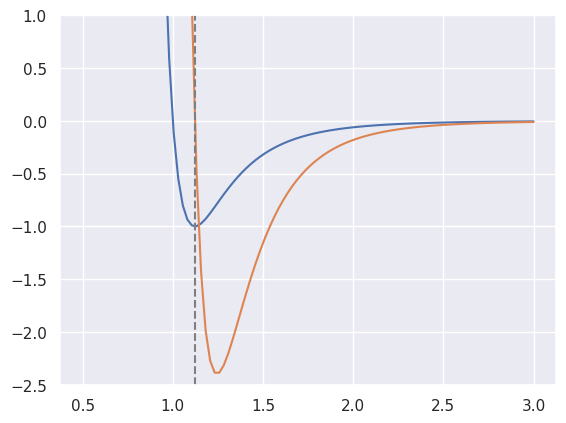

In [3]:
r = torch.linspace(0.5, 3, 100)
V = lennard_jones(r)
F = -dlj_dr(r)
sns.lineplot(x=r, y=V)
sns.lineplot(x=r, y=F)
plt.ylim(-2.5, 1)
plt.gca().axvline(x=2.0 ** (1 / 6), ls="--", c="tab:grey");

In [4]:
F_autograd = -vmap(grad(lennard_jones))(r)
torch.allclose(F_autograd, F)

True

In [5]:
from functorch.compile import print_compile

In [6]:
b = aot_function(lennard_jones, fw_compiler=print_compile, bw_compiler=print_compile)
x = torch.linspace(0, 4, 10, requires_grad=True)
y = b(x)
y.sum().backward()




def forward(self, primals_1):
    _tensor_constant0 = self._tensor_constant0
    lift_fresh_copy = torch.ops.aten.lift_fresh_copy.default(_tensor_constant0);  _tensor_constant0 = None
    _tensor_constant1 = self._tensor_constant1
    lift_fresh_copy_1 = torch.ops.aten.lift_fresh_copy.default(_tensor_constant1);  _tensor_constant1 = None
    div = torch.ops.aten.div.Tensor(lift_fresh_copy, primals_1)
    pow_1 = torch.ops.aten.pow.Tensor_Scalar(div, 2)
    mul = torch.ops.aten.mul.Tensor(pow_1, pow_1)
    mul_1 = torch.ops.aten.mul.Tensor(mul, pow_1)
    _tensor_constant2 = self._tensor_constant2
    lift_fresh_copy_2 = torch.ops.aten.lift_fresh_copy.default(_tensor_constant2);  _tensor_constant2 = None
    mul_2 = torch.ops.aten.mul.Tensor(lift_fresh_copy_2, lift_fresh_copy_1);  lift_fresh_copy_2 = lift_fresh_copy_1 = None
    mul_3 = torch.ops.aten.mul.Tensor(mul_1, mul_1)
    sub = torch.ops.aten.sub.Tensor(mul_3, mul_1);  mul_3 = None
    mul_4 = torch.ops.aten.mul.Tensor(mul_2,

In [7]:
type(b)

function

In [8]:
def gather(x, index):
    return x.index_select(0, index)


b = aot_function(gather, fw_compiler=print_compile, bw_compiler=print_compile)

x = torch.randn(5, 4, requires_grad=True)
index = torch.arange(5)

y = b(x, index)
y.sum().backward()




def forward(self, primals_1, primals_2):
    index_select = torch.ops.aten.index_select.default(primals_1, 0, primals_2);  primals_1 = None
    return [index_select, primals_2]
    



def forward(self, primals_2, tangents_1):
    new_zeros = torch.ops.aten.new_zeros.default(tangents_1, [5, 4], dtype = torch.float32, layout = torch.strided, device = device(type='cpu'))
    index_add = torch.ops.aten.index_add.default(new_zeros, 0, primals_2, tangents_1);  new_zeros = primals_2 = tangents_1 = None
    return [index_add, None]
    


In [9]:
def potential_and_force(r):
    v = lennard_jones(r)
    f = -vmap(grad(lennard_jones))(r)
    return v, f

In [10]:
f = aot_function(potential_and_force, fw_compiler=symbolic_trace)

x = torch.linspace(1, 5, 4, requires_grad=True)
f(x)

/nethome/hatemh/miniforge3/envs/hydronet/lib/python3.8/site-packages/functorch/_src/aot_autograd.py:255: UserWarning: Your compiler for AOTAutograd is returning a a function that doesn't take boxed arguments. Please wrap it with functorch.compile.make_boxed_func or handle the boxed arguments yourself. See https://github.com/pytorch/pytorch/pull/83137#issuecomment-1211320670 for rationale.
  warnings.warn(


(tensor([ 0.0000, -0.0246, -0.0016, -0.0003],
        grad_fn=<CompiledFunctionBackward>),
 tensor([ 2.4000e+01, -6.2944e-02, -2.6912e-03, -3.0716e-04],
        grad_fn=<CompiledFunctionBackward>))

In [11]:
import poptorch

In [12]:
class module(torch.nn.Module):
    def __init__(self, func) -> None:
        super().__init__()
        self.model = func

    def forward(self, x):
        return self.model(x)


poptorch.setLogLevel(0)
m = module(f)
opts = poptorch.Options()
opts.useIpuModel(True)
m = poptorch.inferenceModel(m, opts)
x = torch.linspace(1, 5, 4, requires_grad=False)
m(x)

[15:34:14.798] [poptorch:cpp] [trace] Setting op source to: /tmp/ipykernel_1652158/888324035.py:16
[15:34:14.798] [poptorch:cpp] [debug] [DISPATCHER] Intercepting aten::empty_strided, device ipu:0
[15:34:14.798] [poptorch:cpp] [trace] Created IPU tensor: id 1 impl_ 0x562007f3b320 size [4] strides 1 dtype Float
[15:34:14.798] [poptorch:cpp] [trace] Setting op source to: /tmp/ipykernel_1652158/888324035.py:16
[15:34:14.798] [poptorch:cpp] [trace] Adding 0x562007f3b320 to value mapper 0x56200974f7f8, JIT ir: 6
[15:34:14.798] [poptorch:cpp] [debug] [DISPATCHER] Intercepting aten::copy_
[15:34:14.798] [poptorch:cpp] [trace] [Input] self impl_ 0x562007f3b320 type ipu ID 1 sizes [4] dtype float
[15:34:14.798] [poptorch:cpp] [trace] [Input] src impl_ 0x562009730780 type cpu sizes [4] dtype float
[15:34:14.799] [poptorch:cpp] [trace] Setting op source to: /tmp/ipykernel_1652158/888324035.py:16
[15:34:14.799] [poptorch:cpp] [trace] [DISPATCHER] Copying from CPU tensor 0x562009730780 with data_pt

Error: In poptorch/source/dispatch_tracer/TypeInferenceHandler.cpp:123: 'poptorch_cpp_error': Expected an IPU tensor but got tensor(device=cpu, shape=[], dtype=Float).
Constant tensors should be moved explicitly to the IPU, via cpu_tensor.to("ipu").